## Try Regression with some boosted tree Models 

In [1]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import bcolz
import numpy as np

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [12]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [2]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb

In [3]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression","metric" : "rmse","num_leaves" : 40,
        "learning_rate" : 0.005,"bagging_fraction" : 0.6,"feature_fraction" : 0.6,
        "bagging_frequency" : 6,"bagging_seed" : 42,"verbosity" : -1,"seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [4]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

### Get Training Data 

In [51]:
def GetTrainingData(num_rows, val_fraction, test_fraction):
    val_size = int(num_rows*val_fraction)
    test_size = int(num_rows*test_fraction)
    train_size = num_rows - ( val_size + test_size)
    da = bcolz.open(rootdir='data/processed_main', mode='r')
    X = da[:train_size,:-1]
    Y = da[:train_size,-1:]
    Xv = da[train_size:train_size+val_size,:-1]
    Yv = da[train_size:train_size+val_size,-1:]
    Xt = da[train_size+val_size:train_size+val_size+test_size,:-1]
    Yt = da[train_size+val_size:train_size+val_size+test_size,-1:]
    X=np.nan_to_num(X)
    Y=np.nan_to_num(Y)
    Xv=np.nan_to_num(Xv)
    Yv=np.nan_to_num(Yv)
    Xt=np.nan_to_num(Xt)
    return X, Y[:,0], Xv, Yv[:,0], Xt, Yt[:,0]        

In [52]:
dev_X, dev_y, val_X, val_y, X_test, Y_test = GetTrainingData(100000, 0.2, 0.1)

### Run Cat Boost 

In [53]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=True)

0:	learn: 0.6040799	test: 0.4723125	best: 0.4723125 (0)	total: 33.4ms	remaining: 16.7s
50:	learn: 0.5094505	test: 0.4088016	best: 0.4084841 (38)	total: 1.72s	remaining: 15.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4084840915
bestIteration = 38

Shrink model to first 39 iterations.


In [8]:
pred_test_cat = cb_model.predict(X_test)

### Run XGBoost  (slow to train) 

In [9]:
print("XGB Training Starting")
pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, X_test)
print("XGB Training Completed...")

XGB Training Starting
[0]	train-rmse:0.548405	valid-rmse:0.483846
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.525833	valid-rmse:0.463077
[200]	train-rmse:0.500808	valid-rmse:0.441138
[300]	train-rmse:0.479745	valid-rmse:0.422966
[400]	train-rmse:0.459529	valid-rmse:0.405569
[500]	train-rmse:0.441542	valid-rmse:0.390173
[600]	train-rmse:0.424873	valid-rmse:0.376375
[700]	train-rmse:0.409289	valid-rmse:0.363958
[800]	train-rmse:0.39606	valid-rmse:0.353212
[900]	train-rmse:0.383022	valid-rmse:0.342853
[1000]	train-rmse:0.371063	valid-rmse:0.333726
[1100]	train-rmse:0.359893	valid-rmse:0.32526
[1200]	train-rmse:0.350912	valid-rmse:0.318485
[1300]	train-rmse:0.3408	valid-rmse:0.311264
[1400]	train-rmse:0.330181	valid-rmse:0.304076
[1500]	train-rmse:0.321495	valid-rmse:0.298129
[1600]	train-rmse:0.312943	valid-rmse:0.292487
[1700]	train-rmse:0.305395	valid-rmse:0.287768
[1

### Run LightGBM

In [10]:
# Training LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[150]	training's rmse: 0.423255	valid_1's rmse: 0.34762
[300]	training's rmse: 0.352517	valid_1's rmse: 0.297746
[450]	training's rmse: 0.310828	valid_1's rmse: 0.268979
[600]	training's rmse: 0.28662	valid_1's rmse: 0.255019
[750]	training's rmse: 0.271747	valid_1's rmse: 0.248299
[900]	training's rmse: 0.261388	valid_1's rmse: 0.244779
[1050]	training's rmse: 0.256273	valid_1's rmse: 0.243584
[1200]	training's rmse: 0.252297	valid_1's rmse: 0.242698
[1350]	training's rmse: 0.250161	valid_1's rmse: 0.242368
[1500]	training's rmse: 0.248107	valid_1's rmse: 0.241888
[1650]	training's rmse: 0.245379	valid_1's rmse: 0.241296
[1800]	training's rmse: 0.242822	valid_1's rmse: 0.240924
[1950]	training's rmse: 0.240284	valid_1's rmse: 0.240708
[2100]	training's rmse: 0.238128	valid_1's rmse: 0.240768
Early stopping, best iteration is:
[2007]	training's rmse: 0.239454	valid_1's rmse: 0.240675
LightGBM Training Completed...


In [30]:
ensemble_test = (pred_test_cat*0.1) + (pred_test * 0.8) +  (pred_test_xgb*0.1)
rmse_result = rmse(ensemble_test,Y_test)
print ("RMSE is ", rmse_result )

RMSE is  0.2547276608342758


In [26]:
import matplotlib.pyplot as plt

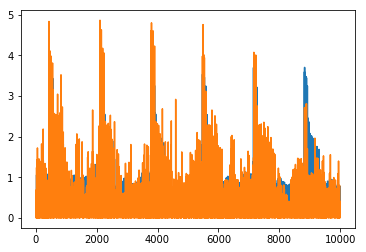

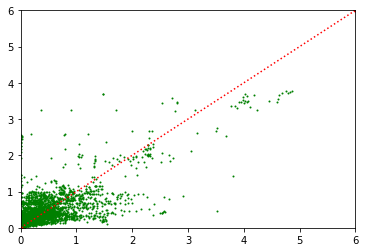

In [44]:
plt.plot(ensemble_test)
plt.plot(Y_test)
plt.show()

plt.scatter(Y_test, ensemble_test, c='green', s=1)
plt.plot([0,6],[0,6], c= "red", marker='.', linestyle=':')
plt.axis([0,6 , 0, 6])
plt.show()
